# Final Project-Course: Machine Learning in Public Informatics
# Project Title: Predicting Car Prices Using Machine Learning

This project focuses on predicting the sale price of used cars listed on Craigslist using machine learning techniques. The goal is to help sellers list their cars at a fair price and assist buyers in assessing car values accurately. With the increasing number of used cars being sold online, an automated and accurate price prediction model can be beneficial for platforms like Craigslist to suggest fair listing prices to users.

The dataset used in this project was sourced from Kaggle's Craigslist Cars and Trucks Data, which contains 14,101 records with 26 columns. These features include key car characteristics such as year, manufacturer, model, odometer, fuel, transmission, lat, and long. The target variable for the prediction is the car's price. By applying machine learning models, this project aims to uncover patterns in the data that contribute to car pricing, ensuring accuracy through systematic preprocessing, model evaluation, and interpretability.

## Links that I borrowed snippets, ideas, and inspiration from for this notebook
  - Kaggle Dataset - https://www.kaggle.com/austinreese/craigslist-carstrucks-data
  
  - Notebooks that inspired this post
      - https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d-abnormals-filter
      - https://www.kaggle.com/jrw2200/smart-pricing-with-xgb-rfr-interpretations
      - https://www.kaggle.com/vbmokin/automatic-selection-from-20-classifier-models
      - https://www.kaggle.com/aantonova/some-new-risk-and-clusters-features

#Step 1: Setup and Libraries

In [1]:
# Install necessary libraries
!pip install pandas numpy seaborn plotly scikit-learn xgboost lightgbm catboost optuna shap lime tensorflow

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
import optuna
import shap
import lime.lime_tabular
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.4 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=12c4a9b5bcb8843215a433ea8a487a8b547e03e4b952c3de846a411a9eb5e8c5
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


#Step 2: Data Loading and Initial Exploration

In [2]:
# Load the dataset
car_data = pd.read_csv("/content/vehicles.csv", sep=",", engine='python', on_bad_lines='skip', encoding='utf-8')

# Basic information about the dataset
print(car_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12175 entries, 0 to 12174
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            12175 non-null  int64  
 1   url           12175 non-null  object 
 2   region        12175 non-null  object 
 3   region_url    12175 non-null  object 
 4   price         12175 non-null  int64  
 5   year          12043 non-null  float64
 6   manufacturer  11576 non-null  object 
 7   model         12007 non-null  object 
 8   condition     6689 non-null   object 
 9   cylinders     8082 non-null   object 
 10  fuel          12039 non-null  object 
 11  odometer      12117 non-null  float64
 12  title_status  11879 non-null  object 
 13  transmission  12091 non-null  object 
 14  VIN           8077 non-null   object 
 15  drive         8550 non-null   object 
 16  size          3258 non-null   object 
 17  type          9840 non-null   object 
 18  paint_color   9422 non-nul

In [3]:
# Summary statistics
print(car_data.describe())


                 id         price          year      odometer  county  \
count  1.217500e+04  1.217500e+04  12043.000000  1.211700e+04     0.0   
mean   7.311030e+09  1.101886e+05   2011.809516  1.020754e+05     NaN   
std    6.439944e+06  8.996473e+06      9.987839  4.175946e+05     NaN   
min    7.208550e+09  0.000000e+00   1901.000000  0.000000e+00     NaN   
25%    7.307289e+09  9.000000e+03   2009.000000  2.808600e+04     NaN   
50%    7.311892e+09  1.945000e+04   2014.000000  6.869600e+04     NaN   
75%    7.315915e+09  2.998900e+04   2018.000000  1.234560e+05     NaN   
max    7.316894e+09  9.876543e+08   2022.000000  1.000000e+07     NaN   

                lat          long  
count  12094.000000  12094.000000  
mean      41.581964   -111.489026  
std       12.679304     26.330783  
min      -81.838232   -158.599600  
25%       33.440000   -148.987200  
50%       34.205600   -111.800000  
75%       61.133360    -86.790000  
max       82.390818    173.885502  


In [4]:
# Check for missing values
print(car_data.isnull().sum())


id                  0
url                 0
region              0
region_url          0
price               0
year              132
manufacturer      599
model             168
condition        5486
cylinders        4093
fuel              136
odometer           58
title_status      296
transmission       84
VIN              4098
drive            3625
size             8917
type             2335
paint_color      2753
image_url          27
description        28
county          12175
state               0
lat                81
long               81
posting_date       27
dtype: int64


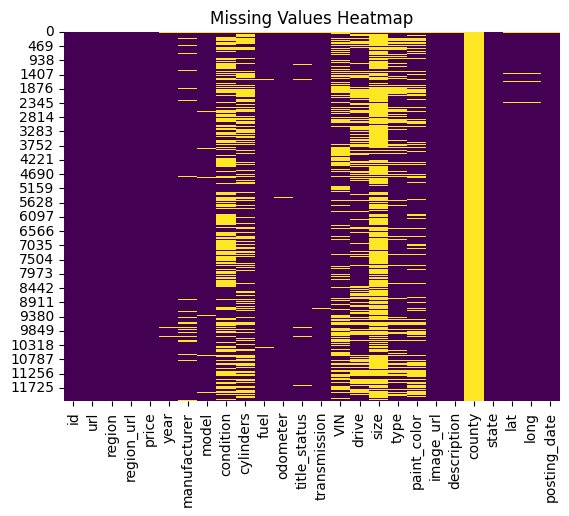

In [5]:
# Visualize missing values using seaborn
sns.heatmap(car_data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

#Step 3: Data Cleaning and Preprocessing

In [6]:

# Drop irrelevant columns
drop_columns = ['url', 'region', 'region_url', 'VIN', 'image_url', 'county', 'description']
car_data = car_data.drop(columns=drop_columns)


In [7]:
# Handle missing values: Impute numerics with median, categoricals with mode
for col in car_data.select_dtypes(include=[np.number]):
    car_data[col].fillna(car_data[col].median(), inplace=True)
for col in car_data.select_dtypes(include=[object]):
    car_data[col].fillna(car_data[col].mode()[0], inplace=True)

In [8]:
# Remove outliers: filter prices to remove near-zero values
car_data = car_data[car_data['price'] > 100]

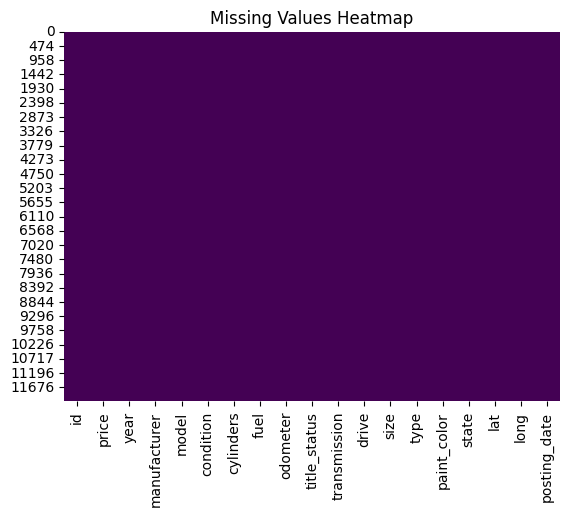

In [9]:
# Recheck missing values
sns.heatmap(car_data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

In [10]:
# Mean encode categorical features
categorical_features = ['manufacturer', 'model', 'condition', 'fuel', 'transmission', 'drive', 'type', 'state', 'cylinders']
for feature in categorical_features:
    mean_encoded_col = car_data.groupby(feature)['price'].mean()
    car_data[feature] = car_data[feature].map(mean_encoded_col)

In [61]:
# Ensure numerical features are non-null and scale them
numerical_features = ['year', 'odometer']
car_data[numerical_features] = car_data[numerical_features].fillna(0)
scaler = QuantileTransformer(output_distribution='normal')
car_data[numerical_features] = scaler.fit_transform(car_data[numerical_features])

In [62]:
# Add interaction terms
car_data['year_odometer'] = car_data['year'] * car_data['odometer']

In [11]:
# Log-transform the target variable
car_data['price'] = np.log1p(car_data['price'])

In [12]:
# Split data into training and testing sets
X = car_data.drop(columns=['price'])
y = car_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

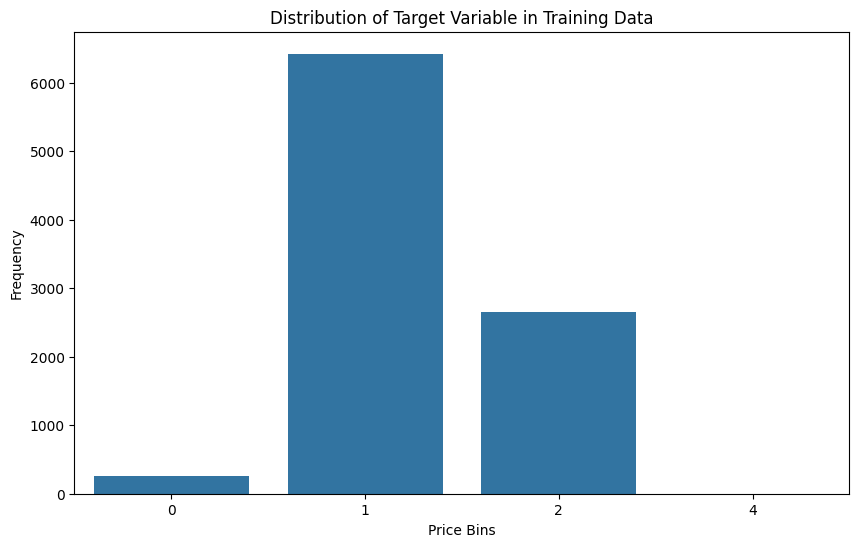

In [13]:
# Check the balance of the target variable
y_train_bins = pd.cut(y_train, bins=5, labels=False, include_lowest=True)
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_bins)
plt.title("Distribution of Target Variable in Training Data")
plt.xlabel("Price Bins")
plt.ylabel("Frequency")
plt.show()

In [14]:
# Balance the data using upsampling
df_train = pd.concat([X_train, y_train], axis=1)
df_train['bin'] = y_train_bins

max_count = df_train['bin'].value_counts().max()
balanced_df = pd.concat([
    resample(df_train[df_train['bin'] == b],
             replace=True,
             n_samples=max_count,
             random_state=42)
    for b in df_train['bin'].unique()
])

In [15]:
# Split the balanced dataset back into X and y
X_train_balanced = balanced_df.drop(columns=['price', 'bin'])
y_train_balanced = balanced_df['price']

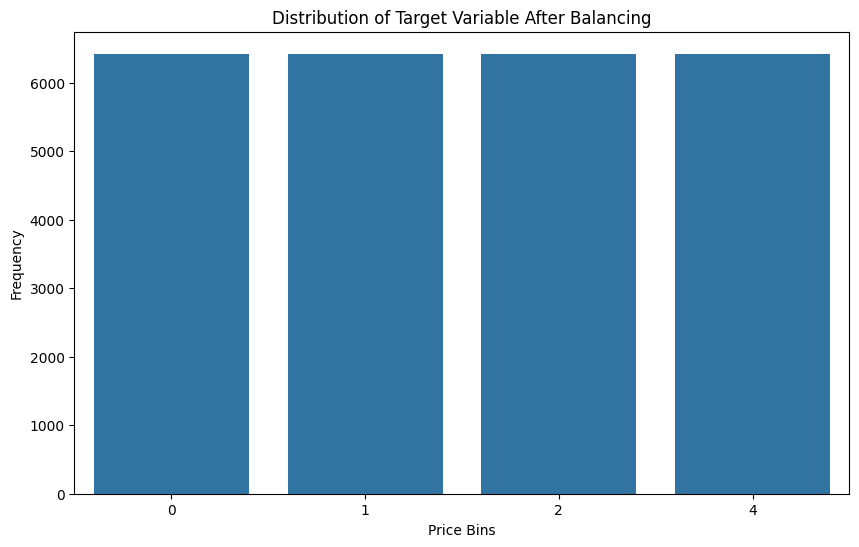

In [16]:
# Verify the balance after upsampling
y_train_balanced_bins = pd.cut(y_train_balanced, bins=5, labels=False, include_lowest=True)
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_balanced_bins)
plt.title("Distribution of Target Variable After Balancing")
plt.xlabel("Price Bins")
plt.ylabel("Frequency")
plt.show()

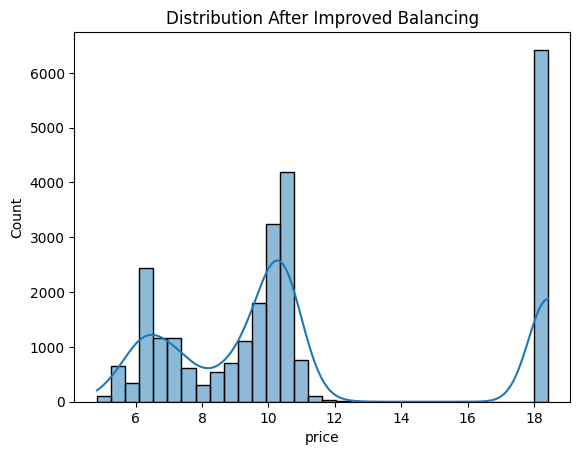

In [17]:
# Verify balance
sns.histplot(y_train_balanced, kde=True)
plt.title("Distribution After Improved Balancing")
plt.show()

# Step 4: Model Training and Optimization

## Evaluate baseline models

In [18]:
# Define baseline models
baseline_models = {
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(objective='reg:squarederror'),
    'LightGBM': LGBMRegressor(),
    'CatBoost': CatBoostRegressor(verbose=0)
}

In [19]:
# Ensure numeric format for modeling
X_train_balanced = X_train_balanced.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)


In [67]:
# Evaluate baseline models with 5-fold cross-validation
from sklearn.base import clone

baseline_results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in baseline_models.items():
    cv_rmse_scores = []

    for train_idx, val_idx in kf.split(X_train_balanced):
        X_train_cv, X_val_cv = X_train_balanced.iloc[train_idx], X_train_balanced.iloc[val_idx]
        y_train_cv, y_val_cv = y_train_balanced.iloc[train_idx], y_train_balanced.iloc[val_idx]

        # Clone and fit the model for each fold
        model_clone = clone(model)
        model_clone.fit(X_train_cv, y_train_cv)

        # Predict and calculate RMSE
        val_predictions = model_clone.predict(X_val_cv)
        val_rmse = np.sqrt(mean_squared_error(y_val_cv, val_predictions))
        cv_rmse_scores.append(val_rmse)

    # Calculate average CV RMSE
    cv_rmse = np.mean(cv_rmse_scores)

    # Evaluate model on test data
    model.fit(X_train_balanced, y_train_balanced)
    test_predictions = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    test_r2 = r2_score(y_test, test_predictions)

    baseline_results[name] = {'CV_RMSE': cv_rmse, 'Test_RMSE': test_rmse, 'Test_R2': test_r2}
    print(f'{name} Baseline - CV_RMSE: {cv_rmse:.4f}, Test_RMSE: {test_rmse:.4f}, Test_R^2: {test_r2:.4f}')


RandomForest Baseline - CV_RMSE: 0.1415, Test_RMSE: 0.4524, Test_R^2: 0.7680
XGBoost Baseline - CV_RMSE: 0.1756, Test_RMSE: 0.4539, Test_R^2: 0.7665
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1412
[LightGBM] [Info] Number of data points in the train set: 20550, number of used features: 14
[LightGBM] [Info] Start training from score 11.217782
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1411
[LightGBM] [Info] Number of data points in the train set: 20550, number of used features: 14
[LightGBM] [Info] Start training from score 11.243799
[LightGBM] [Info] Auto-choosing row-w

## Model Optimization and Evaluate the Optimized Models

In [69]:
# Define hyperparameter optimization functions
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
    }
    model = RandomForestRegressor(**params)
    model.fit(X_train_balanced, y_train_balanced)
    predictions = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, predictions))

def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
    }
    model = XGBRegressor(**params, objective='reg:squarederror')
    model.fit(X_train_balanced, y_train_balanced)
    predictions = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, predictions))

def objective_lgb(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
    }
    model = LGBMRegressor(**params)
    model.fit(X_train_balanced, y_train_balanced)
    predictions = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, predictions))

def objective_cat(trial):
    params = {
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'iterations': trial.suggest_int('iterations', 100, 1000),
    }
    model = CatBoostRegressor(**params, verbose=0)
    model.fit(X_train_balanced, y_train_balanced)
    predictions = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, predictions))

In [70]:
# Optimize models
optimization_functions = {
    'RandomForest': objective_rf,
    'XGBoost': objective_xgb,
    'LightGBM': objective_lgb,
    'CatBoost': objective_cat
}

optimized_models = {}
for name, func in optimization_functions.items():
    study = optuna.create_study(direction='minimize')
    study.optimize(func, n_trials=20)
    print(f"Best hyperparameters for {name}: {study.best_params}")
    if name == 'RandomForest':
        optimized_model = RandomForestRegressor(**study.best_params)
    elif name == 'XGBoost':
        optimized_model = XGBRegressor(**study.best_params, objective='reg:squarederror')
    elif name == 'LightGBM':
        optimized_model = LGBMRegressor(**study.best_params)
    elif name == 'CatBoost':
        optimized_model = CatBoostRegressor(**study.best_params, verbose=0)

    optimized_model.fit(X_train_balanced, y_train_balanced)
    predictions = optimized_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    optimized_models[name] = {'model': optimized_model, 'RMSE': rmse, 'R2': r2}
    print(f'{name} Optimized - RMSE: {rmse}, R^2: {r2}')


[I 2024-12-19 08:19:04,964] A new study created in memory with name: no-name-f6dc1e0d-129f-45dc-bbc1-4edd9b8f436a
[I 2024-12-19 08:19:24,255] Trial 0 finished with value: 0.45750888603299483 and parameters: {'n_estimators': 252, 'max_depth': 13, 'min_samples_split': 7}. Best is trial 0 with value: 0.45750888603299483.
[I 2024-12-19 08:19:59,891] Trial 1 finished with value: 0.4994888855264499 and parameters: {'n_estimators': 513, 'max_depth': 10, 'min_samples_split': 3}. Best is trial 0 with value: 0.45750888603299483.
[I 2024-12-19 08:20:14,475] Trial 2 finished with value: 0.7419416512603562 and parameters: {'n_estimators': 384, 'max_depth': 6, 'min_samples_split': 4}. Best is trial 0 with value: 0.45750888603299483.
[I 2024-12-19 08:21:20,865] Trial 3 finished with value: 0.4476404541691257 and parameters: {'n_estimators': 737, 'max_depth': 18, 'min_samples_split': 8}. Best is trial 3 with value: 0.4476404541691257.
[I 2024-12-19 08:22:25,923] Trial 4 finished with value: 0.46589946

Best hyperparameters for RandomForest: {'n_estimators': 839, 'max_depth': 19, 'min_samples_split': 4}


[I 2024-12-19 08:37:55,179] A new study created in memory with name: no-name-9b930995-1849-490e-a687-e2c4dc215a6d


RandomForest Optimized - RMSE: 0.4437299507952473, R^2: 0.7768447642024313


[I 2024-12-19 08:38:02,935] Trial 0 finished with value: 0.4708651255539306 and parameters: {'max_depth': 7, 'learning_rate': 0.06119577195578134, 'n_estimators': 132}. Best is trial 0 with value: 0.4708651255539306.
[I 2024-12-19 08:38:03,249] Trial 1 finished with value: 0.6262914000052733 and parameters: {'max_depth': 3, 'learning_rate': 0.07872343785572405, 'n_estimators': 229}. Best is trial 0 with value: 0.4708651255539306.
[I 2024-12-19 08:38:05,384] Trial 2 finished with value: 0.4654877396067744 and parameters: {'max_depth': 8, 'learning_rate': 0.26353967920322185, 'n_estimators': 720}. Best is trial 2 with value: 0.4654877396067744.
[I 2024-12-19 08:38:09,668] Trial 3 finished with value: 0.4330095103400932 and parameters: {'max_depth': 9, 'learning_rate': 0.10259299811501896, 'n_estimators': 825}. Best is trial 3 with value: 0.4330095103400932.
[I 2024-12-19 08:38:11,836] Trial 4 finished with value: 0.462049033218376 and parameters: {'max_depth': 9, 'learning_rate': 0.27300

Best hyperparameters for XGBoost: {'max_depth': 7, 'learning_rate': 0.12196395651551797, 'n_estimators': 841}


[I 2024-12-19 08:39:08,609] A new study created in memory with name: no-name-7a8e50d8-3276-48cf-8933-92f9622f665e


XGBoost Optimized - RMSE: 0.4248516658719963, R^2: 0.7954289168288187
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 25688, number of used features: 14
[LightGBM] [Info] Start training from score 11.234104


[I 2024-12-19 08:39:14,682] Trial 0 finished with value: 0.4591038638420871 and parameters: {'num_leaves': 170, 'learning_rate': 0.05761361330001985, 'n_estimators': 678}. Best is trial 0 with value: 0.4591038638420871.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 25688, number of used features: 14
[LightGBM] [Info] Start training from score 11.234104


[I 2024-12-19 08:39:19,476] Trial 1 finished with value: 0.4386604660636157 and parameters: {'num_leaves': 52, 'learning_rate': 0.07207522006152206, 'n_estimators': 960}. Best is trial 1 with value: 0.4386604660636157.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 25688, number of used features: 14
[LightGBM] [Info] Start training from score 11.234104


[I 2024-12-19 08:39:20,530] Trial 2 finished with value: 0.44102483783452057 and parameters: {'num_leaves': 37, 'learning_rate': 0.1189090379071734, 'n_estimators': 403}. Best is trial 1 with value: 0.4386604660636157.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 25688, number of used features: 14
[LightGBM] [Info] Start training from score 11.234104


[I 2024-12-19 08:39:21,340] Trial 3 finished with value: 0.4757724847833401 and parameters: {'num_leaves': 18, 'learning_rate': 0.05002281177127053, 'n_estimators': 438}. Best is trial 1 with value: 0.4386604660636157.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 25688, number of used features: 14
[LightGBM] [Info] Start training from score 11.234104


[I 2024-12-19 08:39:22,151] Trial 4 finished with value: 0.44790541144260865 and parameters: {'num_leaves': 84, 'learning_rate': 0.07814236189767472, 'n_estimators': 204}. Best is trial 1 with value: 0.4386604660636157.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 25688, number of used features: 14
[LightGBM] [Info] Start training from score 11.234104


[I 2024-12-19 08:39:27,221] Trial 5 finished with value: 0.4620376363267612 and parameters: {'num_leaves': 176, 'learning_rate': 0.03369152566475242, 'n_estimators': 796}. Best is trial 1 with value: 0.4386604660636157.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 25688, number of used features: 14
[LightGBM] [Info] Start training from score 11.234104


[I 2024-12-19 08:39:28,482] Trial 6 finished with value: 0.45340408110985625 and parameters: {'num_leaves': 100, 'learning_rate': 0.26580757281863054, 'n_estimators': 323}. Best is trial 1 with value: 0.4386604660636157.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 25688, number of used features: 14
[LightGBM] [Info] Start training from score 11.234104


[I 2024-12-19 08:39:29,628] Trial 7 finished with value: 0.45697915580387405 and parameters: {'num_leaves': 120, 'learning_rate': 0.055376547204743345, 'n_estimators': 230}. Best is trial 1 with value: 0.4386604660636157.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 25688, number of used features: 14
[LightGBM] [Info] Start training from score 11.234104


[I 2024-12-19 08:39:35,592] Trial 8 finished with value: 0.4670714534599595 and parameters: {'num_leaves': 168, 'learning_rate': 0.2643785732401512, 'n_estimators': 620}. Best is trial 1 with value: 0.4386604660636157.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 25688, number of used features: 14
[LightGBM] [Info] Start training from score 11.234104


[I 2024-12-19 08:39:36,292] Trial 9 finished with value: 0.46962372501171956 and parameters: {'num_leaves': 23, 'learning_rate': 0.10931354579533807, 'n_estimators': 180}. Best is trial 1 with value: 0.4386604660636157.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 25688, number of used features: 14
[LightGBM] [Info] Start training from score 11.234104


[I 2024-12-19 08:39:40,669] Trial 10 finished with value: 0.4501102183118135 and parameters: {'num_leaves': 61, 'learning_rate': 0.18816414859061592, 'n_estimators': 966}. Best is trial 1 with value: 0.4386604660636157.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 25688, number of used features: 14
[LightGBM] [Info] Start training from score 11.234104


[I 2024-12-19 08:39:41,907] Trial 11 finished with value: 0.44434699389189364 and parameters: {'num_leaves': 54, 'learning_rate': 0.15110139692982108, 'n_estimators': 462}. Best is trial 1 with value: 0.4386604660636157.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 25688, number of used features: 14
[LightGBM] [Info] Start training from score 11.234104


[I 2024-12-19 08:39:44,447] Trial 12 finished with value: 0.44701224191323286 and parameters: {'num_leaves': 48, 'learning_rate': 0.13673201406462232, 'n_estimators': 999}. Best is trial 1 with value: 0.4386604660636157.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 25688, number of used features: 14
[LightGBM] [Info] Start training from score 11.234104


[I 2024-12-19 08:39:48,620] Trial 13 finished with value: 0.4550771726043241 and parameters: {'num_leaves': 133, 'learning_rate': 0.20929880311537613, 'n_estimators': 821}. Best is trial 1 with value: 0.4386604660636157.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 25688, number of used features: 14
[LightGBM] [Info] Start training from score 11.234104


[I 2024-12-19 08:39:50,418] Trial 14 finished with value: 0.4464311172966907 and parameters: {'num_leaves': 76, 'learning_rate': 0.09877382620120496, 'n_estimators': 487}. Best is trial 1 with value: 0.4386604660636157.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 25688, number of used features: 14
[LightGBM] [Info] Start training from score 11.234104


[I 2024-12-19 08:39:51,606] Trial 15 finished with value: 0.44849431647290233 and parameters: {'num_leaves': 33, 'learning_rate': 0.1909303065588055, 'n_estimators': 346}. Best is trial 1 with value: 0.4386604660636157.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 25688, number of used features: 14
[LightGBM] [Info] Start training from score 11.234104


[I 2024-12-19 08:39:53,394] Trial 16 finished with value: 0.44001669623567813 and parameters: {'num_leaves': 11, 'learning_rate': 0.11878084547849309, 'n_estimators': 777}. Best is trial 1 with value: 0.4386604660636157.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 25688, number of used features: 14
[LightGBM] [Info] Start training from score 11.234104


[I 2024-12-19 08:39:56,485] Trial 17 finished with value: 0.5270855263126035 and parameters: {'num_leaves': 17, 'learning_rate': 0.011921649875836493, 'n_estimators': 851}. Best is trial 1 with value: 0.4386604660636157.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 25688, number of used features: 14
[LightGBM] [Info] Start training from score 11.234104


[I 2024-12-19 08:39:58,483] Trial 18 finished with value: 0.46009498461058695 and parameters: {'num_leaves': 10, 'learning_rate': 0.0820607016414149, 'n_estimators': 743}. Best is trial 1 with value: 0.4386604660636157.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 25688, number of used features: 14
[LightGBM] [Info] Start training from score 11.234104


[I 2024-12-19 08:40:02,333] Trial 19 finished with value: 0.44260721746726533 and parameters: {'num_leaves': 71, 'learning_rate': 0.16761772958358698, 'n_estimators': 897}. Best is trial 1 with value: 0.4386604660636157.


Best hyperparameters for LightGBM: {'num_leaves': 52, 'learning_rate': 0.07207522006152206, 'n_estimators': 960}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 25688, number of used features: 14
[LightGBM] [Info] Start training from score 11.234104


[I 2024-12-19 08:40:04,875] A new study created in memory with name: no-name-64b7574c-fff9-42b8-a9a0-24d82436079a


LightGBM Optimized - RMSE: 0.4386604660636157, R^2: 0.781914603529403


[I 2024-12-19 08:40:10,621] Trial 0 finished with value: 0.4975156750898943 and parameters: {'depth': 10, 'learning_rate': 0.2796406181646325, 'iterations': 258}. Best is trial 0 with value: 0.4975156750898943.
[I 2024-12-19 08:40:14,976] Trial 1 finished with value: 0.5394953227777206 and parameters: {'depth': 3, 'learning_rate': 0.1201458271135045, 'iterations': 626}. Best is trial 0 with value: 0.4975156750898943.
[I 2024-12-19 08:40:24,700] Trial 2 finished with value: 0.48051083349460927 and parameters: {'depth': 9, 'learning_rate': 0.22249885044210696, 'iterations': 552}. Best is trial 2 with value: 0.48051083349460927.
[I 2024-12-19 08:40:29,796] Trial 3 finished with value: 0.44022319425986906 and parameters: {'depth': 7, 'learning_rate': 0.1515910505429699, 'iterations': 870}. Best is trial 3 with value: 0.44022319425986906.
[I 2024-12-19 08:40:35,554] Trial 4 finished with value: 0.5181932548622733 and parameters: {'depth': 3, 'learning_rate': 0.16998398747433113, 'iterations

Best hyperparameters for CatBoost: {'depth': 8, 'learning_rate': 0.14609701673162767, 'iterations': 820}
CatBoost Optimized - RMSE: 0.4289195570509041, R^2: 0.7914926871400617


## Comparison and Select the Best Model after Optimization

In [71]:
# Compare optimized models
print("Model Comparison:")
for model_name, metrics in optimized_models.items():
    print(f"{model_name} - RMSE: {metrics['RMSE']:.4f}, R^2: {metrics['R2']:.4f}")

Model Comparison:
RandomForest - RMSE: 0.4437, R^2: 0.7768
XGBoost - RMSE: 0.4249, R^2: 0.7954
LightGBM - RMSE: 0.4387, R^2: 0.7819
CatBoost - RMSE: 0.4289, R^2: 0.7915


In [72]:
# Select the best model
best_model_name = min(optimized_models, key=lambda x: optimized_models[x]['RMSE'])
print(f"Best Model: {best_model_name} with RMSE: {optimized_models[best_model_name]['RMSE']:.4f} and R^2: {optimized_models[best_model_name]['R2']:.4f}")
final_model = optimized_models[best_model_name]['model']

Best Model: XGBoost with RMSE: 0.4249 and R^2: 0.7954


# Step 5: Feature Importance and Model Interpretability

 99%|===================| 2321/2334 [02:03<00:00]       

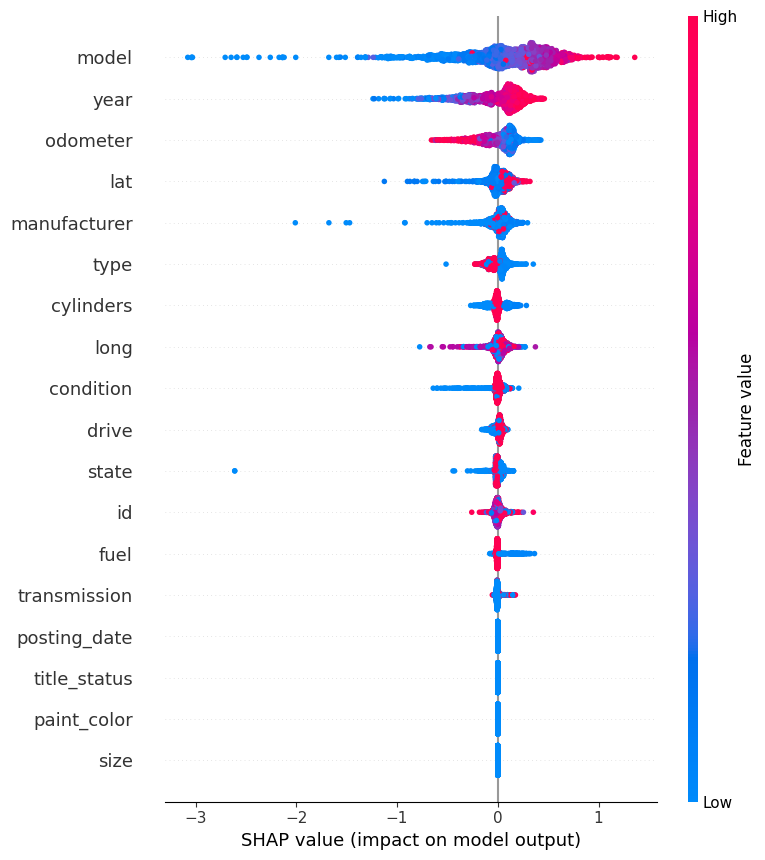

In [73]:
# SHAP for feature importance
shap.initjs()
explainer = shap.Explainer(final_model, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, show=False)

In [75]:
# LIME for local interpretability
X_train_numeric = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test_numeric = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_numeric.values,
    feature_names=X_train.columns,
    class_names=['price'],
    verbose=True,
    mode='regression'
)
exp = lime_explainer.explain_instance(X_test_numeric.iloc[100].values, final_model.predict, num_features=10)
actual_price = np.expm1(y_test.iloc[100])
predicted_price = np.expm1(final_model.predict([X_test_numeric.iloc[1509].values])[0])
print(f"Actual Price: {actual_price}, Predicted Price: {predicted_price}")
exp.show_in_notebook()

Intercept 10.208635730717106
Prediction_local [9.11955326]
Right: 9.609819
Actual Price: 16994.999999999993, Predicted Price: 21286.283203125


In [76]:
# LIME for local interpretability
X_train_numeric = X_train.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test_numeric = X_test.apply(pd.to_numeric, errors='coerce').fillna(0)

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_numeric.values,
    feature_names=X_train.columns,
    class_names=['price'],
    verbose=True,
    mode='regression'
)
exp = lime_explainer.explain_instance(X_test_numeric.iloc[1509].values, final_model.predict, num_features=10)
actual_price = np.expm1(y_test.iloc[150])
predicted_price = np.expm1(final_model.predict([X_test_numeric.iloc[150].values])[0])
print(f"Actual Price: {actual_price}, Predicted Price: {predicted_price}")
exp.show_in_notebook()

Intercept 9.761618050136583
Prediction_local [10.11463801]
Right: 9.965865
Actual Price: 36494.99999999996, Predicted Price: 30958.2890625


We can change the index number in the '.iloc[]' part and check the LIME explanation and visualization of the model's preddicted price for any specific car index.